In [1]:
import numpy
import torch
from VAE1 import AE
from AE import CustomLoss
from data_loader import NEFG3x3Set
import matplotlib.pyplot as plt
import numpy as np
ml = AE(1,[8, 16, 32], 64)



loss_function = torch.nn.L1Loss()
dataset = NEFG3x3Set("info_dat_charge.csv",
                     "data/3x12_16_damp00", "dat_charge", transform=True,device="cpu")
ml.load_state_dict(torch.load("trained_models/conv"))


<All keys matched successfully>

Prediction Loss: tensor(0.2539, grad_fn=<MeanBackward0>)
Input Loss: tensor(0.0052)


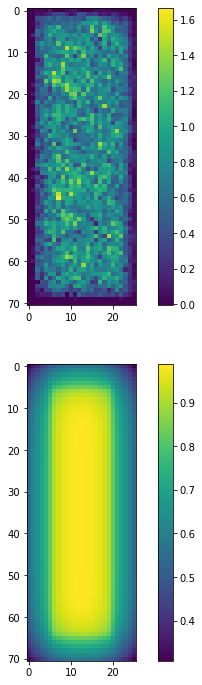

In [2]:

# 1600
# 1500 - example of very small data
# 1000 - very small nums
# 3000 - bigger numbers
(inp,_ ,tar, _,ma,mm)  = dataset[1]
tar = tar.float()
tar = tar.reshape(1,1,71,26).float()
inp = inp.float()
inp = inp.reshape(1,1,71,26).float()

rec  = ml(tar)[0]


fig, ax = plt.subplots(nrows=2, figsize=(8,12))

rec = rec.reshape(1, 1,71,26)
# rec=torch.mm(rec,rec.T)
# print(rec[0][0].detach().numpy())
pos = ax[0].imshow(rec[0][0].detach().numpy())
c_bar = fig.colorbar(pos, ax=ax[0])


# print(tar.min(), tar.max())


# inp=torch.mm(inp,inp.T)
# pos = ax[0].imshow(inp[0][0].detach().numpy())
# c_bar = fig.colorbar(pos, ax=ax[0])



# tar=torch.mm(tar,tar.T)
pos = ax[1].imshow(tar[0][0].detach().numpy())
c_bar = fig.colorbar(pos, ax=ax[1])

# plt.show()

l1 = loss_function(tar, rec)
l2 = loss_function(tar, inp)
print("Prediction Loss:", loss_function(tar, rec))

print("Input Loss:", loss_function(tar, inp))

# 64.7345
# 57.8378